<a id='main'></a>

### Data & Folders
[Data &  Folders](#data_folders)

### Functions
[functions](#functions)

### Plots:


In [1]:
import os
#from VPM_plotting import *
from VPM_plotting_parallel import *
from virusPropagationModel import *

import VPM_plotting as vpm_plot
import get_status_data_and_plots_from_parallel as plt_para
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from functools import partial

%matplotlib inline

<a id='data_folders'></a>
### Data &  Folders 

In [2]:
defaultCmap = cm.get_cmap('Set2')

In [3]:
server_data_folder_str = '/Volumes/Samsung_T5/corona_simulations/simulation_results_20201028/'
scenarios_list = os.listdir(server_data_folder_str)
scenarios_list.sort()
scenarios_list

['base_scenario',
 'close_all_336',
 'close_public_home_office_scan_0.2_0.9',
 'disobedience_scan_0.00_0.45',
 'infectivity_scan_0.025_0.500',
 'infectivity_scan_0.05_0.50',
 'infectivity_scan_0.100_0.500',
 'lockdown_start_scan_100_550',
 'mix_base_scenario',
 'mix_product_0.6',
 'modified_interaction_frequencies_Bad_Feilnbach',
 'modified_interaction_frequencies_Gangelt',
 'no_infections',
 'no_infections_mix',
 'product_0.6_scan_inf_0.075_1.200',
 'recover_from_world_scan_0.5_0.9',
 'recover_interaction_scan_0.5_0.9',
 'recover_ordered1_0.5_0.9',
 'recover_pensioner_infectivity_0.15',
 'recover_random_scan_0.5_0.9',
 'recover_random_scan_0_1',
 'recover_schedule_type',
 'reopen_all_scan_500_1500',
 'reopen_all_scan_672_1344',
 'reopen_public_scan_500_1500',
 'reopen_school_scan_500_1500',
 'reopen_work_scan_500_1500',
 'school_time_separation']

In [4]:
group_folder = 'modified_interaction_frequencies_Gangelt'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

In [5]:
confi_z_dict = { 99 : 2.576, 
                 98 : 2.326,
                 95 : 1.96,
                 90 : 1.645,}
#ci = z*sigma/sqrt(n)

### Function

In [6]:
def get_delta_I(subfolder, data_folder, status='I', digits=7):
    df_I_1 = get_df_total_status(subfolder, data_folder, status=status, digits=digits, time_loc=1)
    df_I_2 = get_df_total_status(subfolder, data_folder, status=status, digits=digits, time_loc=-1)
    return(df_I_2-df_I_1)
    

### Plots

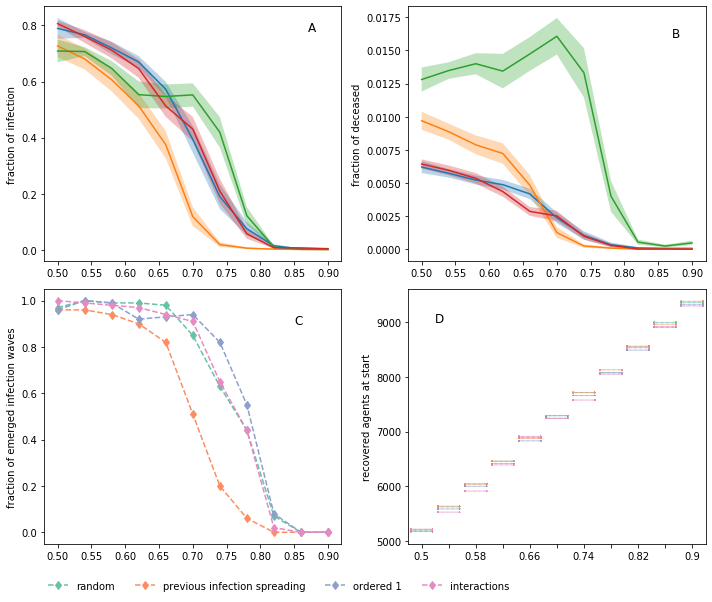

In [55]:
group_folders = ['recover_random_scan_0.5_0.9', 'recover_fromWorld_scan_0.5_0.9', 'recover_ordered1_0.5_0.9', 'recover_interaction_scan_0.5_0.9'] 
legend_lables = ['random','previous infection spreading','ordered 1', 'interactions']
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = os.listdir(data_folder)
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end

col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[99]*df_std.values/np.sqrt(len(df_ratio))

    axes[0][0].plot(df_m.index,df_m.values,)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3)
    axes[0][0].set_ylabel('fraction of infection') 
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()

    CI = confi_z_dict[99]*df_D_std.values/np.sqrt(len(df_ratio))
    axes[0][1].plot(df_D_m)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI,df_D_m.values+CI, alpha=0.3)
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=group_folders[k].split('_')[1], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    
    #control recoverd agents
    sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    axes[1][1].set_ylabel('recovered agents at start')

    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)


# Caption Numbering
axes[0][0].text(0.87,0.78,'A', fontsize=12)
axes[0][1].text(0.87,0.016,'B', fontsize=12)
axes[1][0].text(0.85,0.9,'C', fontsize=12)
axes[1][1].text(0.5,9000,'D', fontsize=12)
    
    
plt.tight_layout()

axes[1][0].legend(legend_lables, markerscale=1, frameon=False, loc=(0,-0.2), ncol=len(legend_lables))


plt.savefig('plots/fig_recover_scans', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

Text(-0.08, 1.08, 'A')

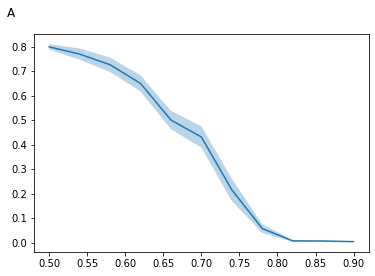

In [45]:
#todo CI intervall plotting
# CI95% -> z =1.96 ci = z*sigma/sqrt(n)
confi_z_dict = { 99 : 2.576,
               98 : 2.326,
               95 : 1.96,
               90 : 1.645,}
df_S = df_S_list[2]
df_ratio = df_delta_I/df_S
#df_ratio.mean().plot()
#plt.errorbar(x=df_ratio.mean().index,y=df_ratio.mean().values,yerr=df_ratio.std().values,fmt='--.')
df_std = df_ratio.std()
df_m = df_ratio.mean()
plt.plot(df_m.index,df_m.values,)#yerr=df_std.values,fmt='--.'
CI = confi_z_dict[99]*df_std.values/np.sqrt(len(df_ratio))
plt.fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3)
df_std*1.96/10
ax =plt.gca()

ax.text(-0.08,1.08,'A', transform=ax.transAxes, fontsize=12)